## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import gc

import matplotlib.pyplot as plt
import json
import pandas as pd
import time
from adamp import AdamP

In [2]:
os.getpid()

1670048

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [6]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [7]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_DIR = os.path.join(ROOT_PATH, 'test')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-8
EARLY_STOPPING_PATIENCE = 6
INPUT_SHAPE = (480, 240)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [8]:
class CustomDataset(Dataset):
    def __init__(self, db, mode):

        self.db = db
        self.mode = mode
        self.transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.RandomHorizontalFlip(p=0.5)])
        
        self.autoaugment = transforms.Compose([
            transforms.RandomApply(nn.ModuleList([
                transforms.AutoAugment()]), p=0.5),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))
        trans_image = TF.crop(trans_image, 0,0,INPUT_SHAPE[1], INPUT_SHAPE[1])
        trans_image = self.autoaugment(trans_image)
        
        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
train_dataset = CustomDataset(db=train_db, mode='train')
validation_dataset = CustomDataset(db=valid_db, mode='val')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [10]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [11]:
import timm

In [12]:
# timm.list_models(pretrained=True)

In [13]:
EFF_BACKBONES = [
    'tf_efficientnetv2_m_in21k'
]
NFN_BACKBONES = [
    'eca_nfnet_l1',
    'dm_nfnet_f2'    
    
]

In [14]:
class DebuggerNet(nn.Module):
    def __init__(self):
        super(DebuggerNet, self).__init__()
        self.conv = nn.Conv2d(3, 3, 3, 3)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.linear = nn.Linear(12, 2)

    def forward(self, input_img):
        x = self.avgpool(input_img)

        x = x.view(-1, 12)
        x = self.linear(x)
        return x


In [15]:
from torch.nn import functional as F
# for efficientnet
class EFFMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(EFFMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x


In [16]:
# for nfnet
class NFNMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(NFNMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

In [17]:
# for deit
class DEITMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(DEITMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        in_features_head = self.model.head.in_features
        in_features_head_dist = self.model.head_dist.in_features
        
        self.model.head = nn.Linear(in_features_head, 2)
        self.model.head_dist = nn.Linear(in_features_head_dist, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## Just Trainer

In [18]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            pred = F.softmax(pred)

            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            pred = F.softmax(pred)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)


## SAM Optimizer w. AdamP

In [19]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

## MultiScale Trainer

In [20]:
class MultiScale_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, scales, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.scales = scales
        self.scales_max_index = len(self.scales) - 1
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = TF.resize(img, self.scales[np.random.randint(0, self.scales_max_index)])
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


# SAM Trainer

In [21]:
class SAM_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
        
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            loss.backward()
            self.optimizer.first_step(zero_grad=True)
            self.criterion(self.model(img), label).backward()
            self.optimizer.second_step(zero_grad=True)
            
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [23]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

#### Test set Loader

In [24]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [25]:
class CheckDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [26]:
def check_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [27]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = check_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [28]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [29]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [30]:
check_dataset = CheckDataset(db=test_db, mode='check', transform=transform)
check_dataloader = DataLoader(check_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


# Misc.

In [32]:
def plot_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

In [33]:
def wait_and_flush():
    
    print("waiting...")
    
    time.sleep(120)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("flushing...")
    time.sleep(60)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("done!")

In [34]:
def pretty_size(size):

    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

# dump_tensors()

# 학습 Function

In [35]:
def EFF_train_val_infer(BACKBONE):
    model = EFFMaskClassifier(BACKBONE).to(device)

    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-5, last_epoch=-1)
    
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    patience = 0
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper
        patience += 1
        
        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            patience = 0
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_AA_best.pt'))
        
        if patience == EARLY_STOPPING_PATIENCE:
            break
            
    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_AA_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())


    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_AA.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_AA_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)

    wait_and_flush()

In [36]:
def NFN_train_val_infer(BACKBONE):
    model = NFNMaskClassifier(BACKBONE).to(device)

    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-5, last_epoch=-1)
    
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    patience = 0
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper
        patience += 1
        
        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            patience = 0
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_AA_best.pt'))
        
        if patience == EARLY_STOPPING_PATIENCE:
            break
            
    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_AA_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())


    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_AA.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_AA_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)

    wait_and_flush()

In [37]:
def DEIT_train_val_infer(BACKBONE):
    model = DEITMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v2.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v2_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

# Debugging Purposes

In [38]:
def DEBUG_train_val_infer(BACKBONE="debug"):
    model = DebuggerNet().to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

In [39]:
# DEBUG_train_val_infer()

# 기차 = Train

In [40]:
save_csv = pd.DataFrame()

# Efficient Family

In [41]:
print(len(EFF_BACKBONES))
print(EFF_BACKBONES)

1
['tf_efficientnetv2_m_in21k']


In [42]:
INDEX = 0

In [43]:
EFF_train_val_infer(EFF_BACKBONES[INDEX])

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2436670553100508, Acc: 0.8975315729047072, ROC: 0.9631752524945195
Epoch 0, Val loss: 0.13288515201113985, Acc: 0.9546125461254612, ROC: 0.9916797118159796


  5%|▌         | 1/20 [11:13<3:33:13, 673.35s/it]

Epoch 1, Train loss: 0.11776280706611479, Acc: 0.9598163030998852, ROC: 0.9927898262011161
Epoch 1, Val loss: 0.10793667254671896, Acc: 0.9630996309963099, ROC: 0.994872963744609


 10%|█         | 2/20 [22:22<3:21:20, 671.12s/it]

Epoch 2, Train loss: 0.07932802548221364, Acc: 0.9754387403641135, ROC: 0.9966026366287575
Epoch 2, Val loss: 0.07795022250864016, Acc: 0.9719557195571956, ROC: 0.9963352836504944


 15%|█▌        | 3/20 [33:31<3:09:48, 669.89s/it]

Epoch 3, Train loss: 0.05859174867502225, Acc: 0.9823273741184189, ROC: 0.9981854912897443
Epoch 3, Val loss: 0.06743492249030202, Acc: 0.9767527675276753, ROC: 0.99718570292503


 20%|██        | 4/20 [44:41<2:58:38, 669.90s/it]

Epoch 4, Train loss: 0.04396741025403736, Acc: 0.9867147777595539, ROC: 0.999024793423458
Epoch 4, Val loss: 0.05652729156251429, Acc: 0.981549815498155, ROC: 0.997749676913123


 25%|██▌       | 5/20 [55:44<2:46:50, 667.34s/it]

Epoch 5, Train loss: 0.026709181223669044, Acc: 0.9924143021157946, ROC: 0.99968167177767
Epoch 5, Val loss: 0.04951755103781132, Acc: 0.9856088560885609, ROC: 0.9980578563749959


 30%|███       | 6/20 [1:06:52<2:35:46, 667.62s/it]

Epoch 6, Train loss: 0.020527772967402824, Acc: 0.9949155322289651, ROC: 0.9998248351910931


 35%|███▌      | 7/20 [1:18:03<2:24:52, 668.67s/it]

Epoch 6, Val loss: 0.057224076693139135, Acc: 0.9782287822878228, ROC: 0.9979112900124777
Epoch 7, Train loss: 0.02707467176868205, Acc: 0.9926193209775299, ROC: 0.99966560571479


 40%|████      | 8/20 [1:29:05<2:13:20, 666.67s/it]

Epoch 7, Val loss: 0.049667353239137756, Acc: 0.9841328413284133, ROC: 0.9977931452639839
Epoch 8, Train loss: 0.018989653086282966, Acc: 0.9948745284566181, ROC: 0.9998513321538985


 45%|████▌     | 9/20 [1:40:14<2:02:21, 667.38s/it]

Epoch 8, Val loss: 0.050311955750916265, Acc: 0.985239852398524, ROC: 0.9979837372639125
Epoch 9, Train loss: 0.014387931840729092, Acc: 0.9960226340823356, ROC: 0.9999124382371691


 50%|█████     | 10/20 [1:51:14<1:50:50, 665.03s/it]

Epoch 9, Val loss: 0.05232564682938633, Acc: 0.9874538745387453, ROC: 0.9980528407960504
Epoch 10, Train loss: 0.008863862829804232, Acc: 0.9974167623421355, ROC: 0.9999688793137448
Epoch 10, Val loss: 0.0403517014163611, Acc: 0.9881918819188192, ROC: 0.9987277148074937


 55%|█████▌    | 11/20 [2:02:22<1:39:54, 666.01s/it]

Epoch 11, Train loss: 0.0077954953317113515, Acc: 0.997744792520912, ROC: 0.9999694297570126
Epoch 11, Val loss: 0.03947664864883401, Acc: 0.988929889298893, ROC: 0.998890999766497


 60%|██████    | 12/20 [2:13:28<1:28:47, 665.90s/it]

Epoch 12, Train loss: 0.005617341112593723, Acc: 0.9983188453337707, ROC: 0.9999883581248853


 65%|██████▌   | 13/20 [2:24:53<1:18:23, 671.91s/it]

Epoch 12, Val loss: 0.04432358988951173, Acc: 0.9900369003690037, ROC: 0.9983203383398099
Epoch 13, Train loss: 0.007494343243708471, Acc: 0.9982778415614236, ROC: 0.9999676683385554


 70%|███████   | 14/20 [2:36:03<1:07:08, 671.36s/it]

Epoch 13, Val loss: 0.0530105717038997, Acc: 0.9856088560885609, ROC: 0.9975730170769318
Epoch 14, Train loss: 0.010868797857894696, Acc: 0.9967607019845826, ROC: 0.9999499715874947


 75%|███████▌  | 15/20 [2:47:08<55:47, 669.41s/it]  

Epoch 14, Val loss: 0.05428198134211807, Acc: 0.9833948339483395, ROC: 0.9978516603516813
Epoch 15, Train loss: 0.00944351384587303, Acc: 0.9976217812038708, ROC: 0.9999482720939052


 80%|████████  | 16/20 [2:58:23<44:43, 670.97s/it]

Epoch 15, Val loss: 0.05354445253510541, Acc: 0.9830258302583026, ROC: 0.997993211135254
Epoch 16, Train loss: 0.006660891706229125, Acc: 0.9984828604231589, ROC: 0.9999797024044985


 85%|████████▌ | 17/20 [3:09:30<33:29, 669.97s/it]

Epoch 16, Val loss: 0.05378042080902835, Acc: 0.9856088560885609, ROC: 0.9977585934979148


 85%|████████▌ | 17/20 [3:16:51<34:44, 694.80s/it]


KeyboardInterrupt: 

### NFNet Family

In [41]:
print(len(NFN_BACKBONES))
print(NFN_BACKBONES)

2
['eca_nfnet_l1', 'dm_nfnet_f2']


In [42]:
INDEX = 0

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.16869012906223418, Acc: 0.9346399868787928, ROC: 0.9842188603165715
Epoch 0, Val loss: 0.13439640543869966, Acc: 0.9564575645756458, ROC: 0.9942092354641555


  5%|▌         | 1/20 [11:09<3:32:04, 669.72s/it]

Epoch 1, Train loss: 0.074237793974051, Acc: 0.9760537969493194, ROC: 0.9968409441610259
Epoch 1, Val loss: 0.07295935647562146, Acc: 0.9771217712177122, ROC: 0.9976549381997081


 10%|█         | 2/20 [22:23<3:21:41, 672.28s/it]

Epoch 2, Train loss: 0.04481957442209056, Acc: 0.986837789076595, ROC: 0.9987949764785959
Epoch 2, Val loss: 0.05055647489295159, Acc: 0.9841328413284133, ROC: 0.9984223217783682


 15%|█▌        | 3/20 [33:36<3:10:31, 672.41s/it]

Epoch 3, Train loss: 0.027794524261382673, Acc: 0.9927833360669182, ROC: 0.999577328375711


 20%|██        | 4/20 [44:47<2:59:11, 671.97s/it]

Epoch 3, Val loss: 0.055892063756321816, Acc: 0.9800738007380074, ROC: 0.998334827790097
Epoch 4, Train loss: 0.01948139081563988, Acc: 0.9948745284566181, ROC: 0.999801310621934
Epoch 4, Val loss: 0.04407707345981934, Acc: 0.9845018450184502, ROC: 0.9988960153454424


 25%|██▌       | 5/20 [56:01<2:48:12, 672.83s/it]

Epoch 5, Train loss: 0.008075106898084132, Acc: 0.9977037887485649, ROC: 0.9999685834504882


 30%|███       | 6/20 [1:07:16<2:37:07, 673.39s/it]

Epoch 5, Val loss: 0.04507311729420395, Acc: 0.9870848708487084, ROC: 0.9985075866204417
Epoch 6, Train loss: 0.005067277289345406, Acc: 0.9987288830572413, ROC: 0.999986245798845


 35%|███▌      | 7/20 [1:18:30<2:25:58, 673.72s/it]

Epoch 6, Val loss: 0.04606750252613241, Acc: 0.9845018450184502, ROC: 0.9984624464099322
Epoch 7, Train loss: 0.010362524748205372, Acc: 0.9972937510250943, ROC: 0.9999436483704554
Epoch 7, Val loss: 0.041416383189604354, Acc: 0.9870848708487084, ROC: 0.9987009650531178


 40%|████      | 8/20 [1:29:43<2:14:42, 673.52s/it]

Epoch 8, Train loss: 0.006434077599771873, Acc: 0.9983188453337707, ROC: 0.9999825027846236
Epoch 8, Val loss: 0.037646852912290966, Acc: 0.9881918819188192, ROC: 0.9991284038365834


 45%|████▌     | 9/20 [1:40:57<2:03:27, 673.40s/it]

Epoch 9, Train loss: 0.0039547271145436765, Acc: 0.9990159094636707, ROC: 0.9999886333465191


 50%|█████     | 10/20 [1:52:06<1:52:01, 672.17s/it]

Epoch 9, Val loss: 0.05345895223191297, Acc: 0.9848708487084871, ROC: 0.9987160117899543
Epoch 10, Train loss: 0.0018803119405430872, Acc: 0.9993849434147941, ROC: 0.999998596369667


 55%|█████▌    | 11/20 [2:03:18<1:40:49, 672.18s/it]

Epoch 10, Val loss: 0.050880615436992266, Acc: 0.9874538745387453, ROC: 0.9986920484683257
Epoch 11, Train loss: 0.0010983598651091073, Acc: 0.9997949811382647, ROC: 0.9999996972562027


 60%|██████    | 12/20 [2:14:30<1:29:36, 672.08s/it]

Epoch 11, Val loss: 0.03979054898745771, Acc: 0.9918819188191882, ROC: 0.9991562681640586
Epoch 12, Train loss: 0.0007778355511761505, Acc: 0.9998359849106118, ROC: 0.999999869269724


 65%|██████▌   | 13/20 [2:25:40<1:18:20, 671.46s/it]

Epoch 12, Val loss: 0.05325504035741397, Acc: 0.9896678966789668, ROC: 0.9990381234155647
Epoch 13, Train loss: 0.002187554191893426, Acc: 0.9995489585041823, ROC: 0.9999983830729008


 70%|███████   | 14/20 [2:36:51<1:07:07, 671.29s/it]

Epoch 13, Val loss: 0.05799002640131318, Acc: 0.9863468634686346, ROC: 0.9983075207491715
Epoch 14, Train loss: 0.003666908452706312, Acc: 0.9989339019189766, ROC: 0.999996607893362


 70%|███████   | 14/20 [2:48:07<1:12:03, 720.50s/it]

Epoch 14, Val loss: 0.04399886849761685, Acc: 0.9885608856088561, ROC: 0.9990955239301631


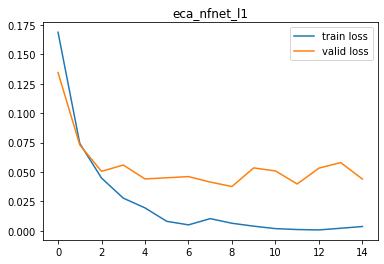

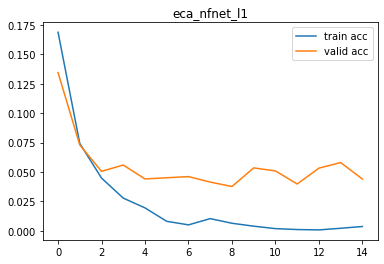

Epoch 0, Val loss: 0.4593419064913178, Acc: 0.8966861598440545, ROC: 0.949732428115016
waiting...
flushing...
done!


In [43]:
NFN_train_val_infer(NFN_BACKBONES[INDEX])

In [44]:
INDEX = 1
NFN_train_val_infer(NFN_BACKBONES[INDEX])

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.4968300081809049, Acc: 0.7620141052976874, ROC: 0.8434700041308014
Epoch 0, Val loss: 0.3602464266077301, Acc: 0.8494464944649447, ROC: 0.9313746197215909


  5%|▌         | 1/20 [43:24<13:44:50, 2604.74s/it]


KeyboardInterrupt: 